In [2]:
from astropy.table import Table, QTable, Column
import numpy as np
import astropy.units as u
from astropy.io import fits as pyfits
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.coordinates import SkyCoord
from photutils import SkyCircularAperture, SkyCircularAnnulus, aperture_photometry
from astropy.io import ascii
from astropy.wcs import WCS
from scipy.stats import norm
import matplotlib.mlab as mlab

##-------------------------Importing Everything I Will Need-----------------------------------##

hdu = pyfits.open('C:/Users/dougl/Desktop/smcw2-nd-intbgsub.fits', ignore_missing_end=True)
w = WCS(hdu[0].header)


In [4]:
from astropy.io import ascii
catalog = Table.read('C:/Users/dougl/Desktop/asu(1).fit', format = 'fits')
print(catalog)

 RAJ2000    IDra    DEJ2000   Umag  e_Umag ... e_Imag Flag Jmag Hmag Ksmag
   deg       h        deg     mag    mag   ...  mag        mag  mag   mag 
--------- -------- --------- ------ ------ ... ------ ---- ---- ---- -----
 5.617095 0.374473 -74.89902  20.53  0.165 ...  0.048   10  nan  nan   nan
 5.617995 0.374533 -74.88598    nan    nan ...    nan    0  nan  nan   nan
 5.618685 0.374579 -74.89183 21.784  0.497 ...  0.149    0  nan  nan   nan
 5.618955 0.374597 -74.89297    nan    nan ...   0.26    0  nan  nan   nan
  5.61939 0.374626 -74.86275    nan    nan ...    nan    0  nan  nan   nan
  5.61969 0.374646 -74.89796    nan    nan ...    nan    0  nan  nan   nan
  5.62077 0.374718 -74.88685    nan    nan ...  0.283    0  nan  nan   nan
 5.622585 0.374839 -74.89294    nan    nan ...  0.321    0  nan  nan   nan
 5.622675 0.374845 -74.89507 20.146  0.164 ...  0.216    0  nan  nan   nan
 5.623395 0.374893 -74.89001 21.913  0.506 ...  0.331    0  nan  nan   nan
      ...      ...       

(24, 14)

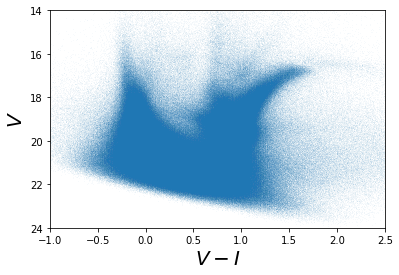

In [24]:
plt.scatter(catalog["Vmag"] - catalog["Imag"], catalog["Vmag"], s=0.002, alpha=0.25)
plt.ylim(reversed(plt.ylim())) # flip the y-axis
plt.xlabel("$V-I$", fontsize=20)
plt.ylabel("$V$", fontsize=20)
plt.xlim(-1,2.5)
plt.ylim(24,14)

(22.5, 14)

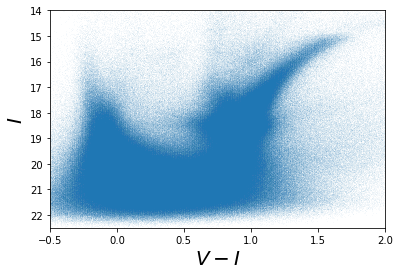

In [29]:
plt.scatter(catalog["Vmag"] - catalog["Imag"], catalog["Imag"], s=0.002, alpha=0.25)
plt.ylim(reversed(plt.ylim()))
plt.xlabel("$V-I$", fontsize=20)
plt.ylabel("$I$", fontsize=20)
plt.xlim(-0.5,2)
plt.ylim(22.5,14)